# Dataiku Sr. Data Scientist Takehome Assignment

## Problem Statement
For this technical assessment, you have been tasked with identifying characteristics that are
associated with a person making more or less than $50,000 per year; the target variable for
your research question is the final column of the datasets.
As the data scientist on this project, you are to attempt to answer this question by constructing a
data analysis/modeling pipeline. Solutions in Python or R are preferred. In the event you would
like to use a different language or tool, please ask. Considerations for your data analysis should
include, but are not limited to, the following:
- Exploratory Data Analysis: Numerical and/or graphical representations of the data that
may help inform insights and/or tactics for answering the research question of interest.
- Data Preparation: Data cleaning, preprocessing, feature engineering, etc., that may aid
in improving data clarity & model generation.
- Data Modeling: The building of a few competing models to predict the target variable.
- Model Assessment: A selection of the best model based on performance comparisons.
- Results: A concise summary of key findings, recommendations, & future improvements.



## Import packages

In [40]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, DMatrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score


from shap import TreeExplainer, summary_plot

## Import training and testing data sets
Note that column names are not included and have been inferred from the metadata file.  
Also, the metadata file says to ignore `instance weight` so dropping that column.

In [2]:
col_names = [
    'age',
    'class_of_worker',
    'detailed_industry_recode',
    'detailed_occupation_recode',
    'education',
    'wage_per_hour',
    'enroll_in_edu_inst_last_wk',
    'marital_status',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'full_or_part_time_employment_status',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'tax_filer_status',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_status',
    'detailed_household_summary_in_household',
    'instance_weight', # ignore!
    'migration_code-change_in_msa',
    'migration_code-change_in_reg',
    'migration_code-move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    'own_business_or_self_employed',
    'fill_inc_questionnaire_for_veterans_admin',
    'veterans_benefits',
    'weeks_worked_in_year',
    'year',
    'income_bucket'
]

# print(len(col_names))
train_df = pd.read_csv('../data/census_income_learn.csv',index_col=None, header=None)
train_df.columns = col_names
train_df = train_df.drop('instance_weight', axis=1) # The metadata file says to ignore instance_weight

test_df = pd.read_csv('../data/census_income_test.csv', index_col=None, header=None)
test_df.columns = col_names
test_df = test_df.drop('instance_weight', axis=1) # The metadata file says to ignore instance_weight

col_names = [col for col in col_names if col != 'instance_weight'] # Remove instance weight from col_names

In [3]:
test_df

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income_bucket
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
99758,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
99759,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
99760,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.


## Organize columns by data type according to the metadata file

In [4]:
numeric_cols = [
    'age',
    'wage_per_hour',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'weeks_worked_in_year'
]
    
cat_cols = [
    'class_of_worker',
    'detailed_industry_recode',
    'detailed_occupation_recode',
    'education',
    'enroll_in_edu_inst_last_wk',
    'marital_status',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'full_or_part_time_employment_status',
    'tax_filer_status',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_status',
    'detailed_household_summary_in_household',
    'migration_code-change_in_msa',
    'migration_code-change_in_reg',
    'migration_code-move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer', # see metadata for category buckets
    'family_members_under_18',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    'own_business_or_self_employed',
    'fill_inc_questionnaire_for_veterans_admin',
    'veterans_benefits',
    'year',
    'income_bucket'
]


len(cat_cols) + len(numeric_cols) ==len(col_names)

True

## Exploratory Data Analysis on Continuous Columns

Note that I'm going to to EDA on just the training data to avoid train-test leakage.

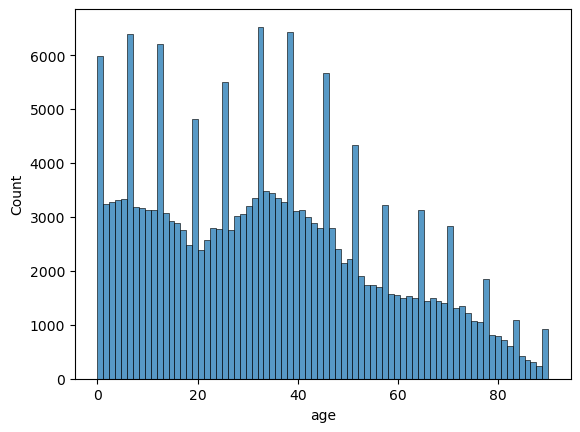

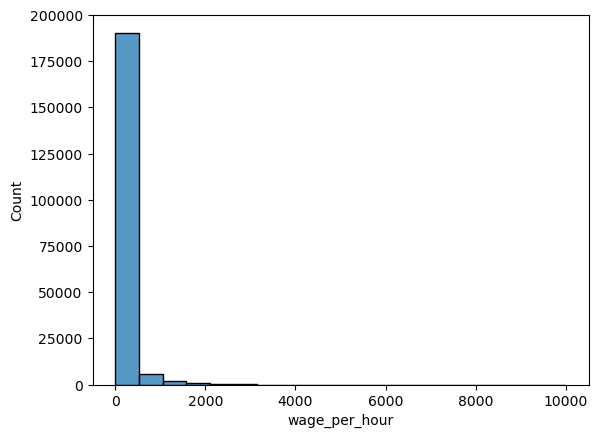

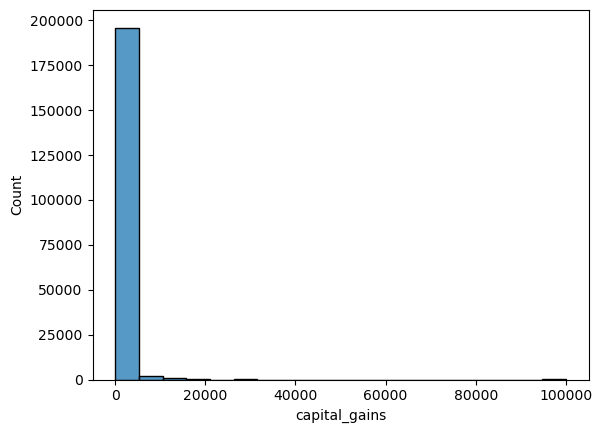

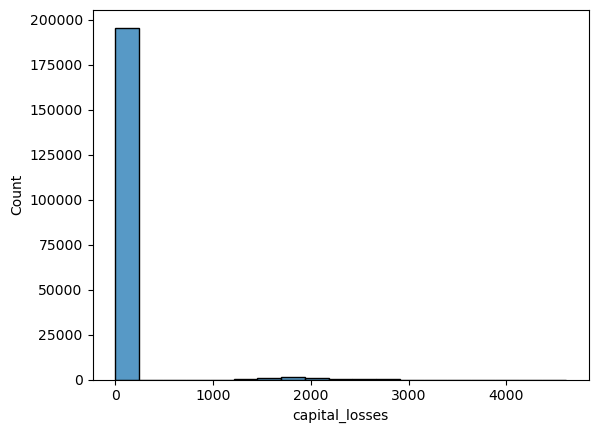

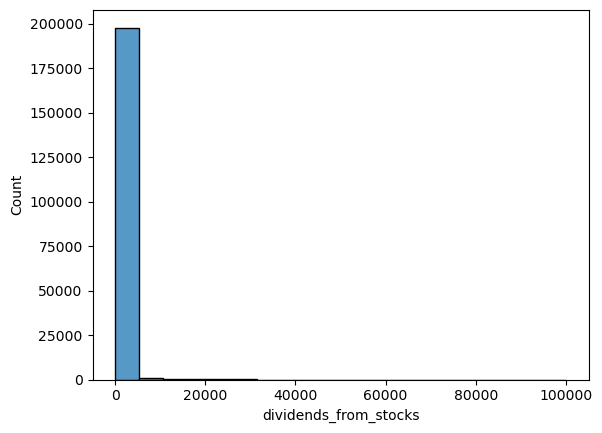

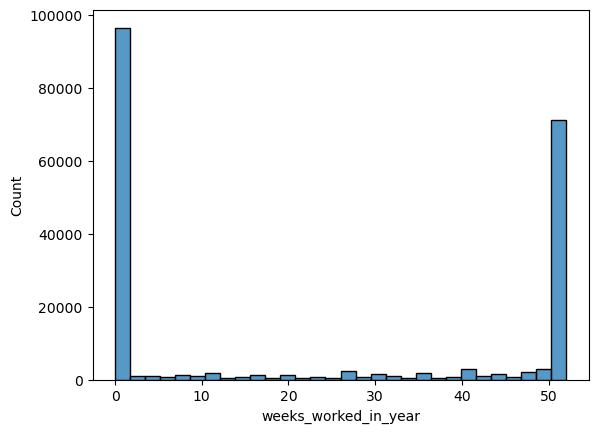

In [5]:
for col in numeric_cols:
    fig, ax = plt.subplots()
    sns.histplot(train_df, x=col, ax=ax)

There are a few values that look like statistical outliers in `wage_per_hour`, `capital_gains`, `capital_losses`, and `dividends_from_stocks` but without knowing more I don't think there's a reason to remove those records.

Now I'll look for missing values.

In [6]:
train_df[numeric_cols].isna().sum()

age                      0
wage_per_hour            0
capital_gains            0
capital_losses           0
dividends_from_stocks    0
weeks_worked_in_year     0
dtype: int64

Looks like there aren't any.

## Exploratory Data Analysis on Categorical Columns

In [7]:
for col in cat_cols:
    print(col)
    print(train_df[col].value_counts())

class_of_worker
 Not in universe                   100245
 Private                            72028
 Self-employed-not incorporated      8445
 Local government                    7784
 State government                    4227
 Self-employed-incorporated          3265
 Federal government                  2925
 Never worked                         439
 Without pay                          165
Name: class_of_worker, dtype: int64
detailed_industry_recode
0     100684
33     17070
43      8283
4       5984
42      4683
45      4482
29      4209
37      4022
41      3964
32      3596
35      3380
39      2937
34      2765
44      2549
2       2196
11      1764
50      1704
40      1651
47      1644
38      1629
24      1503
12      1350
19      1346
30      1181
31      1178
25      1084
9        993
22       952
36       945
13       899
1        827
48       652
27       626
49       610
3        563
21       559
6        554
5        553
8        550
16       539
23       525
18       483

Note that you have to open the results in a text editor to see them all.

Taking a look at the value counts for these columns, I'm going to dig into the migration-related columns with the same number of ' ?' values.

In [8]:
weird_cols = ['migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'migration_prev_res_in_sunbelt']
train_df[train_df['migration_code-change_in_msa'] == ' ?'][weird_cols].value_counts()

migration_code-change_in_msa  migration_code-change_in_reg  migration_code-move_within_reg  migration_prev_res_in_sunbelt
 ?                             ?                             ?                               ?                               99696
dtype: int64

In [9]:
train_df[train_df['migration_code-change_in_msa'] == ' ?']

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income_bucket
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
5,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.
7,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199515,87,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,?,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199517,39,Private,43,26,Bachelors degree(BA AB BS),0,Not in universe,Never married,Education,Adm support including clerical,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,2,Not in universe,2,52,95,- 50000.
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Poland,Poland,Germany,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,95,- 50000.


In [10]:
train_df[train_df['migration_code-change_in_msa'] == ' ?'].shape[0] / train_df.shape[0]

0.4996717170451527

There's a cohort that has missing values for the four migration-related columns. It's also the largest cohort for those columns and it takes up about half of the data se.. It looks like the rest of the columns are populated more normally, though. For now I'll drop those columns, but in the future it may be possible to find a way around the missing data.

In [11]:
cols_to_drop = ['migration_code-change_in_msa', 
                'migration_code-change_in_reg', 
                'migration_code-move_within_reg', 
                'migration_prev_res_in_sunbelt']

There are some missing values denoted with ' ?' in four other columns, but the relative proportion of those values is low so I'll keep them in the dataset but change the value to "unknown."   
I'll also change the target to a binary column.  
I'll create a function for these steps to apply them separately to the training and testing set.

In [12]:
def clean_df(df, cols_to_drop):
    return_df = df.drop(cols_to_drop, axis=1)
    
    return_df['country_of_birth_father'] = return_df['country_of_birth_father'].replace(' ?', 'unknown')
    return_df['country_of_birth_mother'] = return_df['country_of_birth_mother'].replace(' ?', 'unknown')
    return_df['country_of_birth_self'] = return_df['country_of_birth_self'].replace(' ?', 'unknown')
    return_df['state_of_previous_residence'] = return_df['state_of_previous_residence'].replace(' ?', 'unknown') # could maybe interpolate this to 'Not in universe' but not sure.
    
    return_df['income_greater_than_50k?'] = return_df['income_bucket'] == ' 50000+.'
    return_df = return_df.drop('income_bucket', axis=1)

    return return_df


In [13]:
clean_train_df = clean_df(train_df, cols_to_drop)
clean_test_df = clean_df(test_df, cols_to_drop)

In [14]:
final_cat_cols = list(set(cat_cols) - set(cols_to_drop) - set(['income_bucket']))
final_numeric_cols = list(set(numeric_cols) - set(cols_to_drop))
target_col = 'income_greater_than_50k?'

for col in final_cat_cols:
    print(col)
    print(clean_train_df[col].value_counts())

citizenship
 Native- Born in the United States              176992
 Foreign born- Not a citizen of U S              13401
 Foreign born- U S citizen by naturalization      5855
 Native- Born abroad of American Parent(s)        1756
 Native- Born in Puerto Rico or U S Outlying      1519
Name: citizenship, dtype: int64
veterans_benefits
2    150130
0     47409
1      1984
Name: veterans_benefits, dtype: int64
major_industry_code
 Not in universe or children            100684
 Retail trade                            17070
 Manufacturing-durable goods              9015
 Education                                8283
 Manufacturing-nondurable goods           6897
 Finance insurance and real estate        6145
 Construction                             5984
 Business and repair services             5651
 Medical except hospital                  4683
 Public administration                    4610
 Other professional services              4482
 Transportation                           4209
 Hosp

Finally I'll double check for any missing values.

In [15]:
clean_train_df.isna().sum()

age                                          0
class_of_worker                              0
detailed_industry_recode                     0
detailed_occupation_recode                   0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_status                               0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_a_labor_union                      0
reason_for_unemployment                      0
full_or_part_time_employment_status          0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_status                             0
region_of_previous_residence                 0
state_of_prev

I'll also look at the incidence of the positive target class.

In [16]:
print(sum(clean_train_df['income_greater_than_50k?'] == 1))
print(sum(clean_train_df['income_greater_than_50k?'] == 1) / clean_train_df.shape[0])

12382
0.06205800834991455


We have a low positive class incidence which will dictate how we measure model performance down the road. We also have the same count of the positive class as earlier in the EDA which is a good quality check.

## Prepare the data preprocessing and modeling pipeline
I'll apply a standard scaler (subtract the mean and divide by the standard deviation) to center each feature around zero and have uniform variance.  
I'll also apply a one-hot encoder to the categorical columns.

In [17]:
X_train = clean_train_df.drop(target_col, axis=1)
y_train = clean_train_df[target_col]

X_test = clean_test_df.drop(target_col, axis=1)
y_test = clean_test_df[target_col]

In [18]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, final_numeric_cols),
        ("cat", categorical_transformer, final_cat_cols),
    ]
)

Quick check for rank deficiency.

In [19]:
preprocessor.fit_transform(X_train).shape

(199523, 483)

We're good

In [20]:
logistic_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
)

decision_tree = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

random_forest = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

xgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier())]
)


## Logistic Regression Results

In [21]:
logistic_reg.fit(X_train, y_train)
y_lr_test_preds = logistic_reg.predict(X_test)

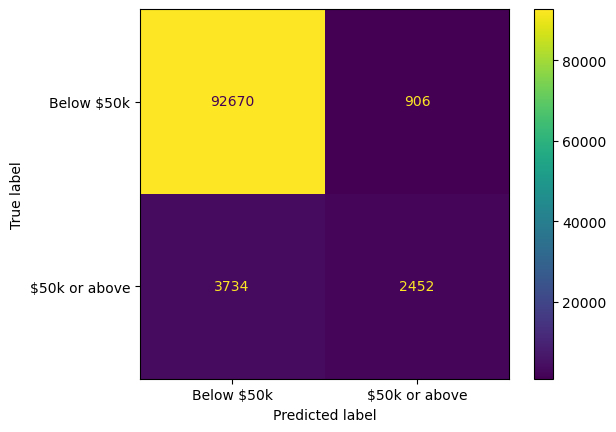

In [22]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_lr_test_preds), display_labels=['Below $50k', '$50k or above']).plot()

In [23]:
print(classification_report(y_test, y_lr_test_preds))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98     93576
        True       0.73      0.40      0.51      6186

    accuracy                           0.95     99762
   macro avg       0.85      0.69      0.74     99762
weighted avg       0.95      0.95      0.95     99762



## Decision Tree

In [24]:
decision_tree.fit(X_train, y_train)
y_dt_test_preds = decision_tree.predict(X_test)

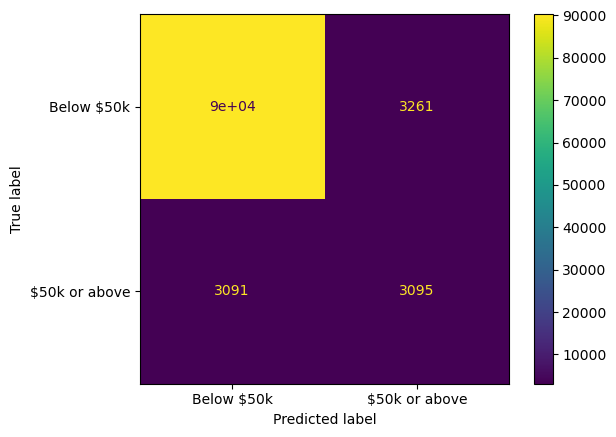

In [25]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_dt_test_preds), display_labels=['Below $50k', '$50k or above']).plot()

In [26]:
print(classification_report(y_test, y_dt_test_preds))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97     93576
        True       0.49      0.50      0.49      6186

    accuracy                           0.94     99762
   macro avg       0.73      0.73      0.73     99762
weighted avg       0.94      0.94      0.94     99762



## Random Forest

In [27]:
random_forest.fit(X_train, y_train)
y_rf_test_preds = random_forest.predict(X_test)

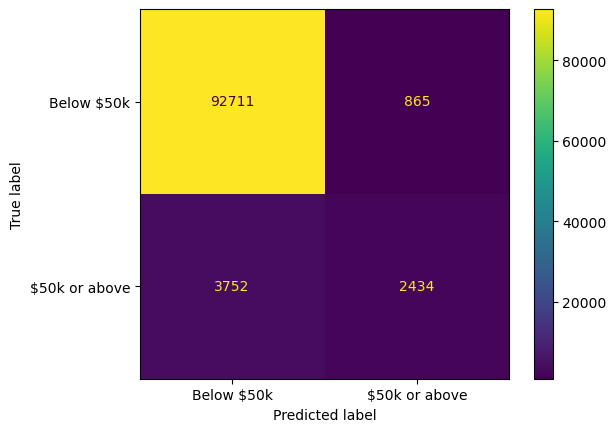

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_rf_test_preds), display_labels=['Below $50k', '$50k or above']).plot()

In [29]:
print(classification_report(y_test, y_dt_test_preds))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97     93576
        True       0.49      0.50      0.49      6186

    accuracy                           0.94     99762
   macro avg       0.73      0.73      0.73     99762
weighted avg       0.94      0.94      0.94     99762



## XGBoost

In [30]:
xgb.fit(X_train, y_train)
y_xgb_test_preds = xgb.predict(X_test)

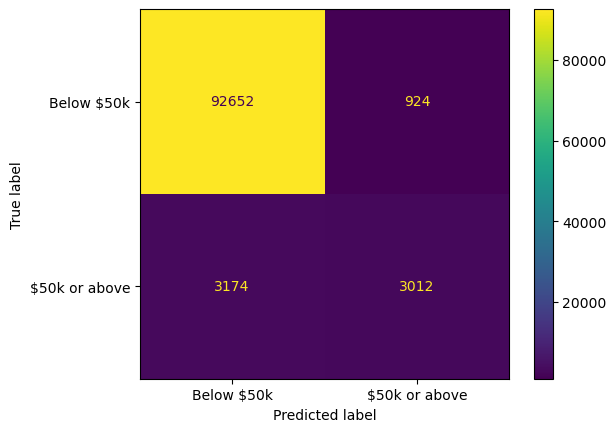

In [31]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_xgb_test_preds), display_labels=['Below $50k', '$50k or above']).plot()

In [32]:
print(classification_report(y_test, y_xgb_test_preds))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     93576
        True       0.77      0.49      0.60      6186

    accuracy                           0.96     99762
   macro avg       0.87      0.74      0.79     99762
weighted avg       0.95      0.96      0.95     99762



## Model Explanations

In [55]:
xgboost_model = xgb.named_steps['classifier']
preprocessor.fit(X_train)
explainer = TreeExplainer(xgboost_model)


X_test_transformed = pd.DataFrame(preprocessor.transform(X_test).toarray(), columns=preprocessor.get_feature_names_out())
shap_values = explainer.shap_values(np.array(X_test_transformed))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


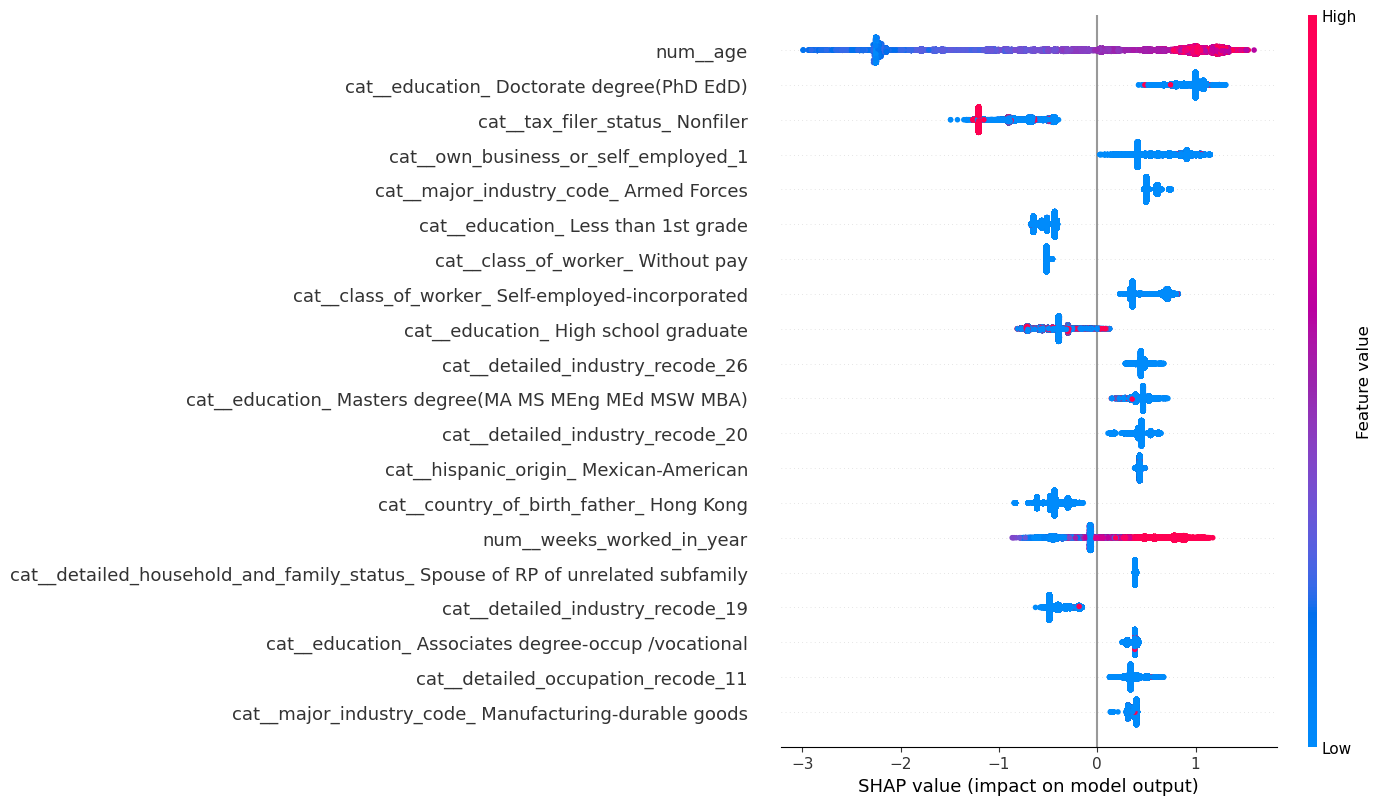

In [56]:
summary_plot(shap_values, X_test_transformed)